<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Light-transport-analysis" data-toc-modified-id="Light-transport-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Light transport analysis</a></span><ul class="toc-item"><li><span><a href="#Approximation-of-the-light-transport-matrix" data-toc-modified-id="Approximation-of-the-light-transport-matrix-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Approximation of the light transport matrix</a></span></li><li><span><a href="#Scene-compensation" data-toc-modified-id="Scene-compensation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Scene compensation</a></span></li><li><span><a href="#Light-transport-matrix-probing" data-toc-modified-id="Light-transport-matrix-probing-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Light transport matrix probing</a></span></li></ul></li></ul></div>

# Light transport analysis

In this exercise, we will try to approximate the light transport matrix of a scene modeled in Mitsuba to gain practical experience with the theory provided in the lecture.

You can use the provided method `project_and_acquire(texture)` for projecting the image in the parameter `texture` onto the scene and obtaining the corresponding image as the return value.

The function models a coaxial camera and projector setup.

Please note: To significantly increase the rendering speed, you can install LLVM and then rely on the LLVM variant of Mitsuba.

Some initialization code:

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

#variant = "scalar_rgb"
#variant = "cuda_ad_rgb"
variant = "llvm_ad_rgb"

import os as os
os.environ["DRJIT_LIBLLVM_PATH"] = "C:\\Program Files\\LLVM\\bin\\LLVM-C.dll"
os.environ["MI_DEFAULT_VARIANT"] = variant

import drjit as dr
import mitsuba as mi


import matplotlib.pyplot as plt

mi.set_variant(variant)

def imshow(img, cmap=None):
    plt.close('all')
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.show()

In [3]:
shape = (256, 256) # Reduce this if you experience any memory problems.

In [4]:
def project_and_acquire(texture):
    scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'path'
    },

    'rect' : {
        'type': 'rectangle',
        'bsdf' : {
            'type' : 'diffuse'
        },
        'flip_normals' : True,
        'to_world': mi.ScalarTransform4f.translate(mi.ScalarPoint3f(0,0,10))@mi.ScalarTransform4f.scale(mi.ScalarPoint3f(2000,2000,2000))
    },
    
    'sphere1' : {
        'type': 'sphere',
        'bsdf' : {
            'type' : 'dielectric'
        },
        'center': [2, 2, 4],
        'radius': 0.8,
    },
    
    'sphere2' : {
        'type': 'sphere',
        'bsdf' : {
            'type' : 'thindielectric'
        },
        'center': [0, 2, 5],
        'radius': 1.5,
    },    
    
    'sphere3' : {
        'type': 'sphere',
        'bsdf' : {
            'type': 'plastic',
            'diffuse_reflectance': {
                'type': 'rgb',
                'value': [0.1, 0.1, 0.1]
            },
            'int_ior': 1.9
        },
        'center': [-2, 2, 4],
        'radius': 0.8,
    },   
    
    'sphere4' : {
        'type': 'sphere',
        'bsdf' : {
            'type': 'roughplastic',
            'distribution': 'beckmann',
            'alpha' : 0.1,
            'int_ior': 1.61,
            'diffuse_reflectance': {
                'type': 'rgb',
                'value': [0.1, 0.1, 0.1]
            }
        },
        'center': [2, 0, 4],
        'radius': 0.8,
    },   
    
    'bunny' : {
        'type': 'ply',
        'filename': 'bunny.ply',
        'flip_normals': False,
        'to_world': mi.ScalarTransform4f.translate(mi.ScalarPoint3f(-1.0,-2.5,4))@mi.ScalarTransform4f.scale(mi.ScalarPoint3f(15.0,15.0,15.0)) \
                    @mi.ScalarTransform4f.rotate(mi.ScalarPoint3f(0.0,1.0,0.0),  180),
        'bsdf' : {
            'type': 'conductor',
            'material': 'Ag'
        },
    },
    

    'emitter_id' : {
        
        'type': 'projector',
        'irradiance' : {
            'type': 'bitmap',
            'bitmap' : mi.Bitmap(texture),
            'wrap_mode': 'mirror'
        },
        'fov': 80,
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'scale':70.0
    },
    
    
    'sensor': {
        'type': 'perspective',
        'fov': 80,
        'to_world': mi.ScalarTransform4f.look_at(
            origin=[0, 0, 0],
            target=[0, 0, 1],
            up=[0, 1, 0]
        ),
        'film': {'type': 'hdrfilm',
        'width': shape[1],
        'height': shape[0],
        'rfilter': {'type': 'gaussian'},
        'pixel_format': 'rgb',
        'component_format': 'float32'},
        'sampler': {'type': 'independent', 'sample_count': 32},
    }
    })
        
    img = mi.render(scene)
    
    return img

Get a feeling of how the scene looks like by projecting a constant white image onto the scene:

2023-12-20 10:44:38 WARN main [PLYMesh] "bunny.ply": performance warning -- this file uses the ASCII PLY format, which is slow to parse. Consider converting it to the binary PLY format.

2023-12-20 10:44:38 WARN main [PLYMesh] "bunny.ply": attributes without postfix are not handled for now: attribute "confidence" ignored.

2023-12-20 10:44:38 WARN main [PLYMesh] "bunny.ply": attributes without postfix are not handled for now: attribute "intensity" ignored.

<IPython.core.display.Javascript object>


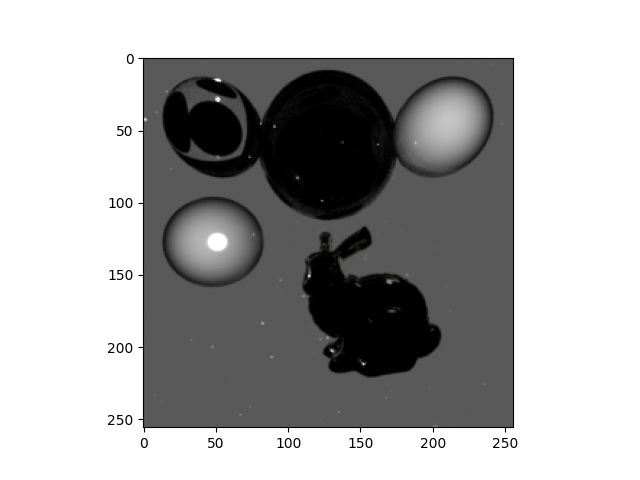

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [5]:
image = project_and_acquire(np.ones((256,256)))
imshow(image)

Don't get confused with the wird content of the image. Essentially the scene consists out of some spheres with different material properties and the Stanford Bunny made out of silver.

## Approximation of the light transport matrix

Implement the Arnoldi method and use it to approximate the light transport matrix of the modeled scene.

Try it for different numbers of iterations to see how the result changes.

In [6]:
def optArnoldi(K):
    i = np.zeros((shape[0]*shape[1], K))
    p = np.zeros((shape[0]*shape[1], K+1))
    
    p[:,0] = (a:=255*np.ones(shape[0]*shape[1]))/np.linalg.norm(a)
    
    for k in range(0,K):
        print(k/K * 100)
        #i[:,k] = A@p[:,k]
        curTexture = np.zeros((shape[0], shape[1], 3), dtype=np.float32)
        curTexture[:,:,0] = np.reshape(p[:,k], (shape[0], shape[1]))
        curTexture[:,:,1] = np.reshape(p[:,k], (shape[0], shape[1]))
        curTexture[:,:,2] = np.reshape(p[:,k], (shape[0], shape[1]))
        
        curTexturePlus = curTexture.copy()
        curTexturePlus[curTexturePlus <= 0] = 0
        
        curTextureMinus = curTexture.copy()
        curTextureMinus[curTextureMinus > 0] = 0
        curTextureMinus = -1 * curTextureMinus
        
               
        acq_img_plus = project_and_acquire(curTexturePlus)
        acq_img_minus= project_and_acquire(curTextureMinus)
        
        acq_img = acq_img_plus - acq_img_minus
        
        i[:,k] = np.reshape(acq_img[:,:,0], (shape[0]*shape[1]))
        
        P = p[:,0:k+1]

        #p[:,k+1] = i[:,k] - P@np.linalg.inv(P.transpose() @ P)@P.transpose()@i[:,k]
        
        d = P.transpose()@i[:,k]
        c = np.linalg.inv(P.transpose() @ P)
        b = d@c
        p[:,k+1] = i[:,k] - P@b
        
        p[:,k+1] = p[:,k+1] / np.linalg.norm(p[:,k+1])
        
    return i, p[:,:-1]

In [7]:
K = 50
I = np.load("ex3_arnoldi_I.npy")
P = np.load("ex3_arnoldi_P.npy")

In [ ]:
K = 50
I,P = optArnoldi(K)

In [ ]:
np.save("ex3_arnoldi_I", I)
np.save("ex3_arnoldi_P", P)

In [8]:
def approx_image(a,b,illum):
    illum_vector = np.reshape(illum, (shape[0] * shape[1]))
    tmp = b.transpose()@illum_vector
    return np.reshape(a@tmp, (shape[0], shape[1]))

In [9]:
def normalize(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))

In [10]:
I.shape

(65536, 50)

In [11]:
errors = []
for k in range(0,K):
    approx_img = approx_image(I[:,0:k+1],P[:,0:k+1], 255*np.ones((256,256)))
    errors.append(np.sum(np.abs(normalize(image)[:,:,0] - normalize(approx_img))))

<IPython.core.display.Javascript object>


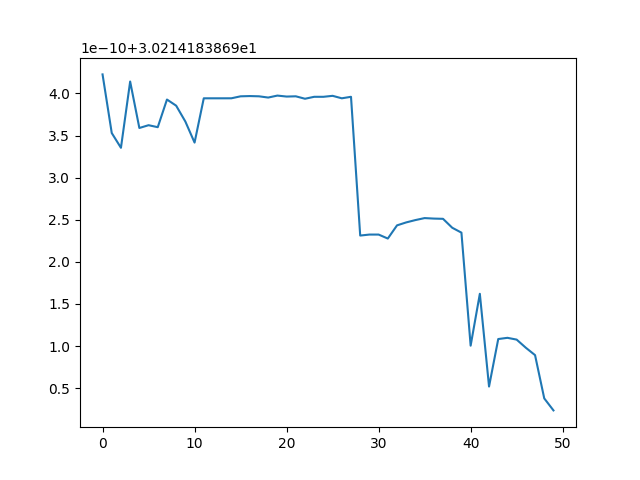

In [12]:
plt.figure()
plt.plot(errors)

<IPython.core.display.Javascript object>


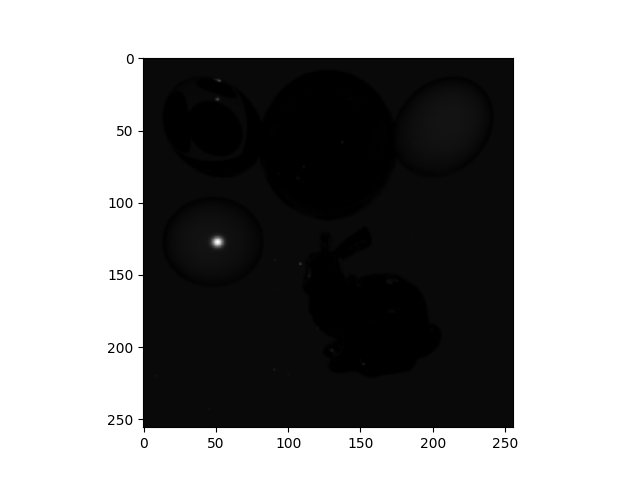

In [13]:
imshow(normalize(approx_img), cmap='gray')

<IPython.core.display.Javascript object>


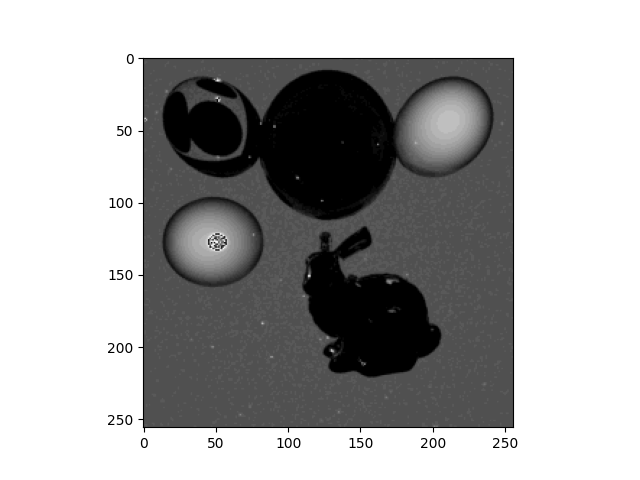

In [14]:
imshow(10*np.uint8(255*normalize(image)[:,:,0]), cmap='gray')

<IPython.core.display.Javascript object>


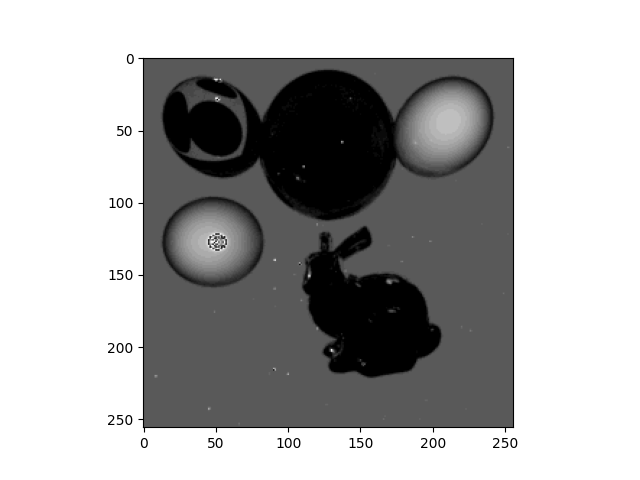

In [15]:
imshow(10*np.uint8(255*normalize(approx_img)[:,:]), cmap='gray')

<IPython.core.display.Javascript object>


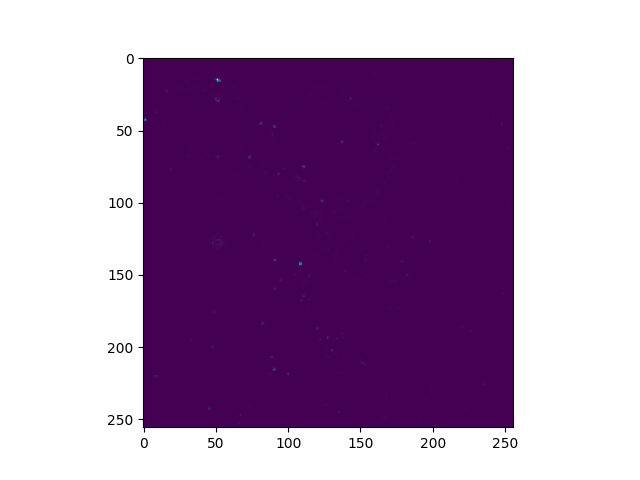

In [16]:
imshow(np.abs(normalize(image)[:,:,0] - normalize(approx_img)))

## Scene compensation

Implement the optical GMRES algorithm to calculate an illumination image that leads to a camera image that is as close to a constant white image as possible.

In [17]:
def optGMRES(K,init_image:np.ndarray):
    i = np.zeros((shape[0]*shape[1], K))
    p = np.zeros((shape[0]*shape[1], K+1))
    
    p[:,0] = (a:=init_image.reshape((shape[0]*shape[1])))/np.linalg.norm(a)
    
    for k in range(0,K):
        print(k/K * 100)
        #i[:,k] = A@p[:,k]
        curTexture = np.zeros((shape[0], shape[1], 3), dtype=np.float32)
        curTexture[:,:,0] = np.reshape(p[:,k], (shape[0], shape[1]))
        curTexture[:,:,1] = np.reshape(p[:,k], (shape[0], shape[1]))
        curTexture[:,:,2] = np.reshape(p[:,k], (shape[0], shape[1]))
        
        curTexturePlus = curTexture.copy()
        curTexturePlus[curTexturePlus <= 0] = 0
        
        curTextureMinus = curTexture.copy()
        curTextureMinus[curTextureMinus > 0] = 0
        curTextureMinus = -1 * curTextureMinus
        
               
        acq_img_plus = project_and_acquire(curTexturePlus)
        acq_img_minus= project_and_acquire(curTextureMinus)
        
        acq_img = acq_img_plus - acq_img_minus
        
        i[:,k] = np.reshape(acq_img[:,:,0], (shape[0]*shape[1]))
        
        P = p[:,0:k+1]

        #p[:,k+1] = i[:,k] - P@np.linalg.inv(P.transpose() @ P)@P.transpose()@i[:,k]
        
        d = P.transpose()@i[:,k]
        c = np.linalg.inv(P.transpose() @ P)
        b = d@c
        p[:,k+1] = i[:,k] - P@b
        
        p[:,k+1] = p[:,k+1] / np.linalg.norm(p[:,k+1])
        
    return i, p[:,:-1]

In [18]:
K = 50
I2 = np.load("ex3_arnoldi_I2.npy")
P2 = np.load("ex3_arnoldi_P2.npy")

In [ ]:
K = 50
I2,P2 = optGMRES(K, 255*np.ones((shape[0], shape[1])))

In [ ]:
np.save("ex3_arnoldi_I2", I2)
np.save("ex3_arnoldi_P2", P2)

In [19]:
#I2inv = np.linalg.pinv(I2)
P2inv = np.linalg.pinv(P2)

In [33]:
def approx_illum(a,b,target_image):
    target_image = np.reshape(target_image, (shape[0] * shape[1]))
    tmp = b@target_image
    return np.reshape(a@tmp, (shape[0], shape[1]))

In [34]:
test = approx_illum(I2,P2inv, 255*np.ones((shape[0], shape[1])))

In [35]:
res_inv = project_and_acquire(test)

2023-12-20 16:13:26 WARN main [PLYMesh] "bunny.ply": performance warning -- this file uses the ASCII PLY format, which is slow to parse. Consider converting it to the binary PLY format.

2023-12-20 16:13:26 WARN main [PLYMesh] "bunny.ply": attributes without postfix are not handled for now: attribute "confidence" ignored.

2023-12-20 16:13:26 WARN main [PLYMesh] "bunny.ply": attributes without postfix are not handled for now: attribute "intensity" ignored.

2023-12-20 16:13:26 WARN main [BitmapTexture] BitmapTexture: texture named "" contains pixels that exceed the [0, 1] range!

<IPython.core.display.Javascript object>


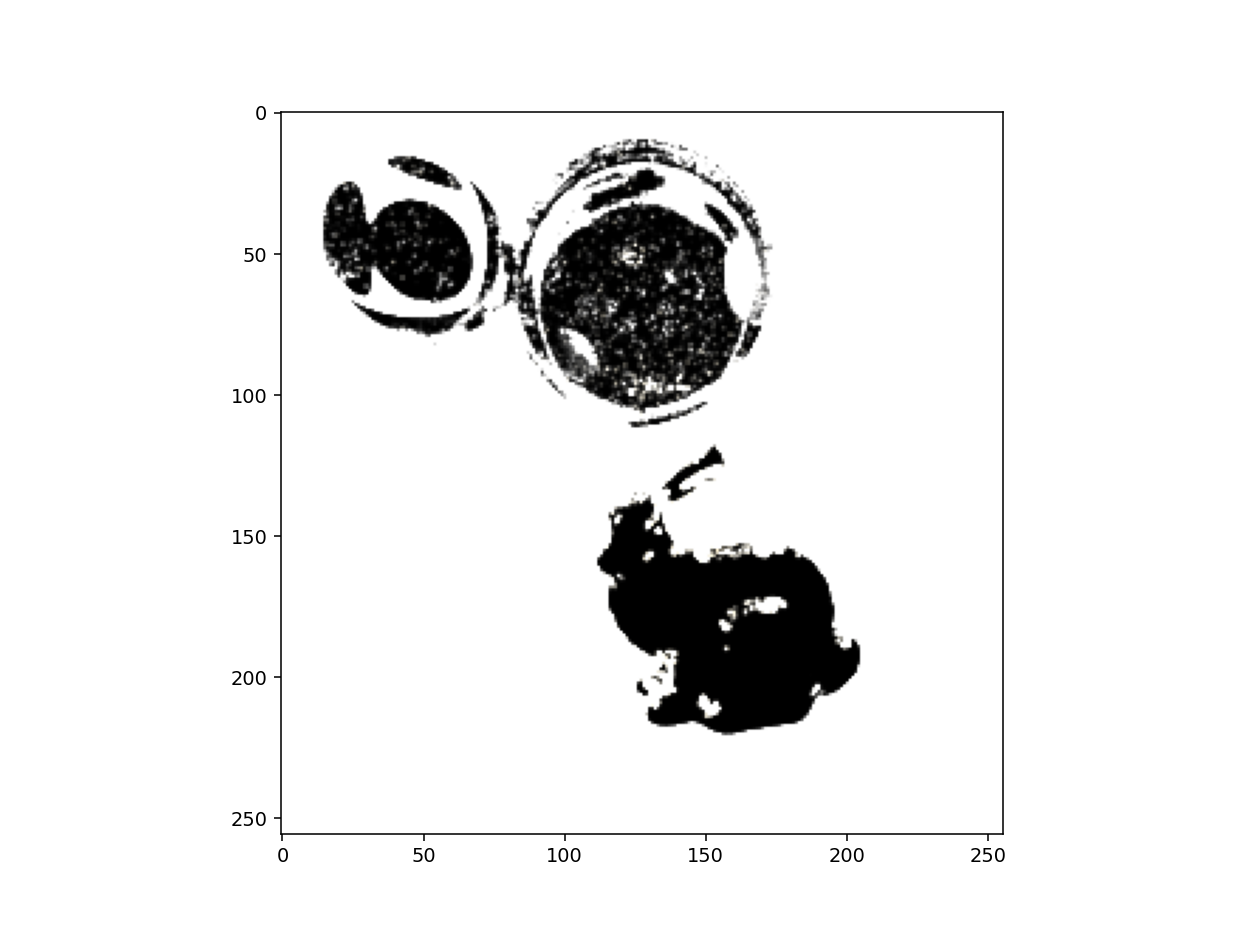

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [36]:
imshow(res_inv)

## Light transport matrix probing

Implement light transport matrix probing to obtain images where
1. the direct component has been enhanced,
2. local scattering has been attenuated and
3. indirect light transport has been enhanced.

In [ ]:
p = 0.5
K = 100
ps = np.random.binomial(1,p, size=(K,100))
imshow(ps.transpose()@ps)

In [24]:
p = 0.5
K = 50
ps = np.random.binomial(1,p, size=(K,shape[0]*shape[1]))
ms = ps.copy()

In [ ]:
p = 0.5
K = 50
ps = np.random.binomial(1,p, size=(K,100))
ms = ps.copy()

In [ ]:
ps.shape

In [25]:
res = np.load("ex3_probing_res.npy")

In [ ]:
res = np.zeros(shape)
for k in range(0,K):
    curImg = project_and_acquire(ps[k,:].reshape(shape))
    res = res + curImg[:,:,0] * ms[k,:].reshape(shape)
    

In [ ]:
np.save("ex3_probing_res", res)

<IPython.core.display.Javascript object>


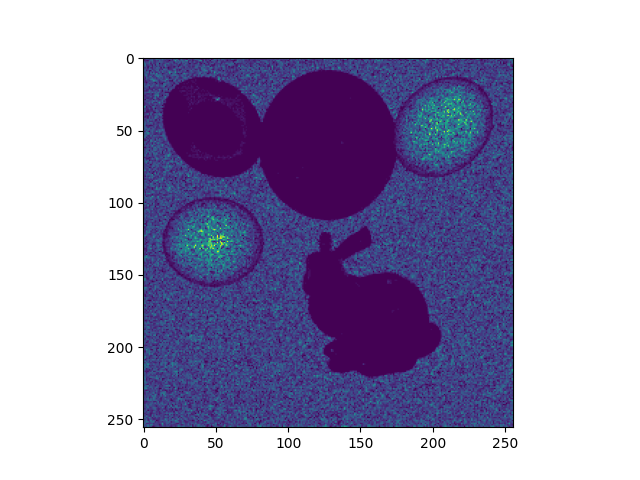

In [26]:
imshow(10*np.uint8(255*normalize(res)))

In [27]:
res_2 = np.load("ex3_probing_res_2.npy")

In [ ]:
res_2 = np.zeros(shape)
ps_shifted = np.roll(ps,1)

for k in range(0,K):
    curImg = project_and_acquire(ps_shifted[k,:].reshape(shape))
    res_2 = res_2 + curImg[:,:,0] * ms[k,:].reshape(shape)
    

In [ ]:
np.save("ex3_probing_res_2", res_2)

<IPython.core.display.Javascript object>


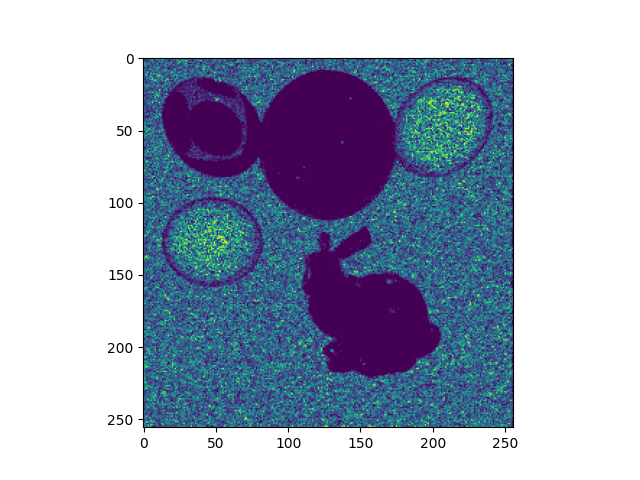

In [28]:
imshow(20*np.uint8(255*normalize(res_2)))

<IPython.core.display.Javascript object>


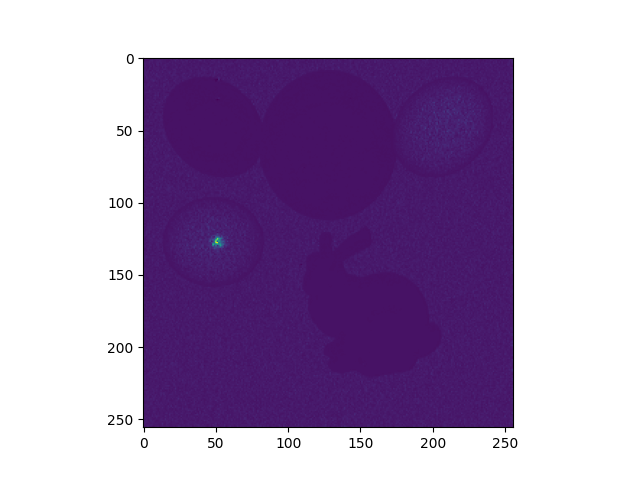

In [29]:
imshow(res-res_2)

In [30]:
res_3 = np.load("ex3_probing_res_3.npy")

In [ ]:
res_3 = np.zeros(shape)

for k in range(0,K):
    curImg = project_and_acquire(ps[k,:].reshape(shape))
    res_3 = res_3 + curImg[:,:,0] * (1-ps[k,:].reshape(shape))
    

In [ ]:
np.save("ex3_probing_res_3", res_3)

<IPython.core.display.Javascript object>


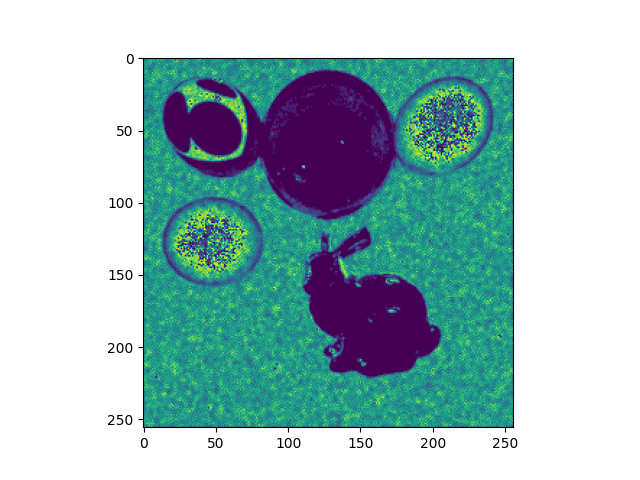

In [31]:
imshow(20*np.uint8(255*normalize(res_3)))